# Welcome to the contact insulation notebook!

Insulation is a simple concept, yet a powerful way to look at C data. If you were to slide a diamond-shaped window along the genome with one of the corners on the main diagonal of the matrix, and sum up the total interactions within the window for each position, you would find that the result is relatively stable across the genome, but certain locations have lower score. These would be insulating boundaries: there are fewer interactions, that encompass these locations, and therefore they have the potential to be domain boundaries.
In this notebook we:
- Calculate the insulation score genome-wide and display it alongside an interaction matrix
- Call insulating boundaries
- Filter insulating boundaries based on their strength
- Calculate enrichment of CTCF/genes at boundaries
- Repeat boundary filtering based on enrichmnent of CTCF, a known insulator protein in mammalian genomes

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools.insulation import calculate_insulation_score, find_boundaries

## Calculating genome-wide contact insulation
Here we load the Hi-C data at 1 kbp resolution and calculate insulation score with 4 different window sizes

In [3]:
clr = cooler.Cooler('test.mcool::resolutions/1000')
insulation = calculate_insulation_score(clr, [3000, 5000, 10000, 25000], verbose=True)

INFO:root:Processing chr2
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Processing chr17


In [4]:
insulation.iloc[1000:1005]

,chrom,start,end,is_bad_bin,log2_insulation_score_3000,n_valid_pixels_3000,log2_insulation_score_5000,n_valid_pixels_5000,log2_insulation_score_10000,n_valid_pixels_10000,log2_insulation_score_25000,n_valid_pixels_25000
1000,chr2,1000000,1001000,False,-0.095267,6.0,-0.084323,22.0,-0.041989,97.0,0.061618,597.0
1001,chr2,1001000,1002000,False,0.041712,6.0,-0.065991,22.0,-0.019041,97.0,0.078254,597.0
1002,chr2,1002000,1003000,False,0.058296,6.0,0.014266,22.0,0.018272,97.0,0.093288,597.0
1003,chr2,1003000,1004000,False,0.052065,6.0,-0.005012,22.0,0.003246,97.0,0.077201,597.0
1004,chr2,1004000,1005000,False,0.010391,6.0,-0.063679,22.0,0.071084,87.0,0.055302,597.0


In [5]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

Let's see what the insulation track at the highest resolution looks like, next to a rotated Hi-C matrix.

/home/ilya/miniconda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


(10500000, 10750000)

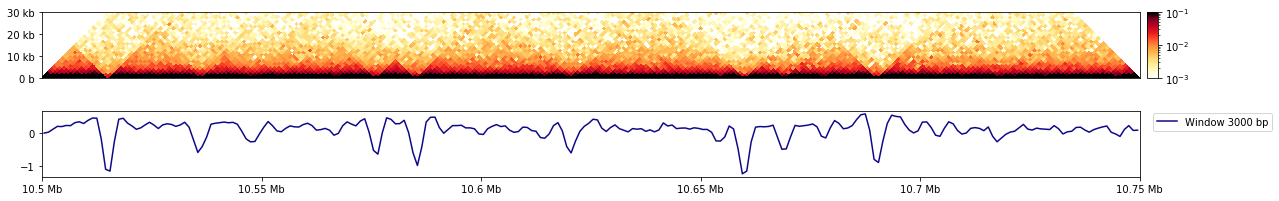

In [6]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid import make_axes_locatable
import bioframe

region = ('chr2', 10_500_000, 10_750_000)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(20, 4))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=1000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 30000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_3000'], label='Window 3000 bp')

ins_ax.legend(bbox_to_anchor=(1.125, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

And now let's add the other window sizes.

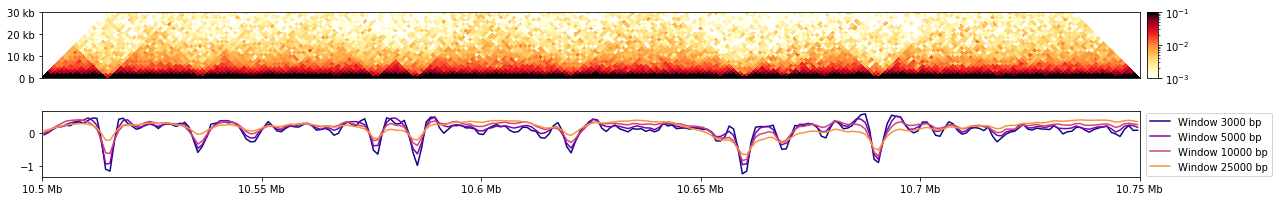

In [7]:
for res in 5000, 10000, 25000:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(1.125, 1.05), loc='upper right')
f

This really highlights how much the result is dependent on window size: smaller windows provide greater sensitivity to subtle changes in insulation, but they are affected by random fluctuations in contact frequency.

## Boundary calling

Now we can annotate valleys of insulation score, which correspond to highly insulating regions, such as TAD boundaries.

In [8]:
insulation = find_boundaries(insulation)

In [9]:
insulation.iloc[1000:1005]

,chrom,start,end,is_bad_bin,log2_insulation_score_3000,n_valid_pixels_3000,log2_insulation_score_5000,n_valid_pixels_5000,log2_insulation_score_10000,n_valid_pixels_10000,log2_insulation_score_25000,n_valid_pixels_25000,boundary_strength_3000,boundary_strength_10000,boundary_strength_5000,boundary_strength_25000
1000,chr2,1000000,1001000,False,-0.095267,6.0,-0.084323,22.0,-0.041989,97.0,0.061618,597.0,0.132509,0.102013,0.098588,0.031671
1001,chr2,1001000,1002000,False,0.041712,6.0,-0.065991,22.0,-0.019041,97.0,0.078254,597.0,NaN,NaN,NaN,NaN
1002,chr2,1002000,1003000,False,0.058296,6.0,0.014266,22.0,0.018272,97.0,0.093288,597.0,NaN,NaN,NaN,NaN
1003,chr2,1003000,1004000,False,0.052065,6.0,-0.005012,22.0,0.003246,97.0,0.077201,597.0,NaN,0.015027,NaN,NaN
1004,chr2,1004000,1005000,False,0.010391,6.0,-0.063679,22.0,0.071084,87.0,0.055302,597.0,NaN,NaN,NaN,NaN


Let's repeat the previous plot using the 5 kbp window size and show where we found the boundaries, without any additional filtering:

(10500000, 10750000)

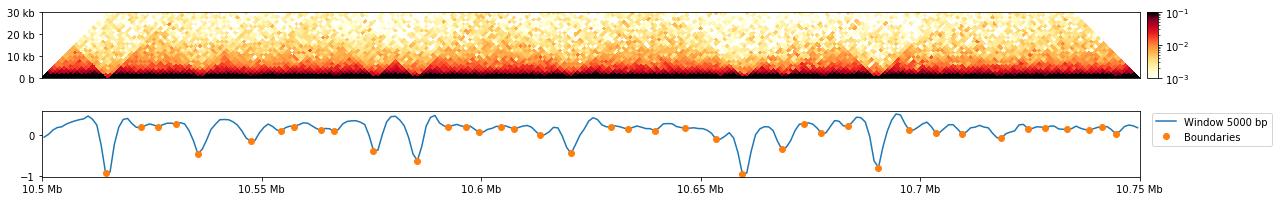

In [10]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=1000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 30000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_5000'], label='Window 5000 bp')
boundaries = insul_region[~np.isnan(insul_region['boundary_strength_5000'])]
ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries['log2_insulation_score_5000'], 'o', label='Boundaries')

ins_ax.legend(bbox_to_anchor=(1.125, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])